In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.pca_translation_utils import *


warnings.filterwarnings('ignore')

In [2]:
from utils.pca_translation_utils import *
from sklearn.decomposition import *

def get_pca_model(data, key, library, n_components=16):
    lib_key = library[:library.index('library')]
    path = os.path.dirname(data['links'].get(key, getlink=True).filename)
    pca_name = os.path.join(path, lib_key+'PCA.pkl')
    if os.path.exists(pca_name):
        print('Found PCA for %s dataset!' % key)
        return pk.load(open(pca_name, 'rb'))
    else:
        print('Building PCA for %s dataset' % key)
        y0 = []
        with h5py.File(os.path.join(path, 'library_PCA.h5'), 'r') as h5f:
            for eId in h5f.keys():
                if not library in h5f[eId]:
                    continue
                y0i = h5f[eId][library][key][()]
                t = y0i.shape[0]
                h, w = y0i.shape[-2:]
                y0.append(y0i.reshape([t, -1, h, w]))
        y0 = np.concatenate(y0, axis=0)
        model = PCA(n_components=n_components, whiten=True)
        model.fit(y0.reshape([y0.shape[0], -1]))
        pk.dump(model, open(pca_name, 'wb'))
        return model
    
def get_control_timeline(data, libraries):
    links = data.require_group('links')
    t_min, t_max = -1e5, 1e5 
    for key in links:
        if key in libraries:  #Skip dynamic fields when assessing control field timeline
            continue
        time = links[key]['time'] + data['U_raw'].attrs['offset']
        t_min = max(np.min(time), t_min)
        t_max = min(np.max(time), t_max)
    print('Control time range: [%d, %d]' % (t_min, t_max))
    
    return np.arange(t_min, t_max+1)

def get_translation_features(data, target):
    '''
    Figure out which terms should go in a translation library
    Crucially, we eliminate features which contain information 
        about target
    '''
    features = list(data['X_raw'].keys())
    to_remove = []
    for i, feature in enumerate(features):
        #The path is /embryo/links/<key>/tensor_library/<feature>
        link_path = data['X_raw'].get(feature, getlink=True).path
        feat_key = link_path.split('/')[-3]
        if feat_key == target:
            to_remove.append(feature)
    features = [f for f in features if not f in to_remove]
    return features

from scipy.ndimage import gaussian_filter
def smooth_stack(field, **kwargs):
    shaped = field.reshape([field.shape[0], -1, *field.shape[-2:]])
    output = np.stack([
        np.stack([
            gaussian_filter(shaped[t, c], **kwargs) \
            for c in range(shaped.shape[1])]) \
        for t in range(shaped.shape[0])])
    return output.reshape(field.shape)

def pca_translation_library(data, libraries, library, re_pca=False, smooth_U=3):
    '''
    Create PCA libraries from the accumulated data
    Each PCA library should be of shape [T, P, L]
        T = time
        P = num PCA components
        L = library size
    
    Each library FOLDER should have an attribute ['t'] which
        indicates the timestamps for each element of that folder
    
    X_pca - the PCA libraries for fields live-imaged with each embryo (dynamic fields)
        These do NOT include any coupling to flow, or fields related to the target field
        Translation does not allow instantaneous feedback
    U_pca - the PCA libraries for static-imaged ensemble-calculated fields (control fields)
    y0_pca - the PCA libraries for the target field within that folder
    If the PCA for a given field has already been computed, we don't re-compute it to save time
    '''
    
    X_pca = data.require_group('X_pca')
    y0_pca = data.require_group('y0_pca')
    U_pca = data.require_group('U_pca')

    X_pca.attrs['t'] = data['t']
    y0_pca.attrs['t'] = data['t']
    U_pca.attrs['t'] = get_control_timeline(data, libraries)
    t_min, t_max = U_pca.attrs['t'].min(), U_pca.attrs['t'].max()
    
    for key in libraries:
        features = get_translation_features(data, key)
        controls = list(data['U_raw'].keys())
        pca = get_pca_model(data, key, library)
        
        X = np.empty([X_pca.attrs['t'].shape[0], pca.n_components, len(features)])
        U = np.empty([t_max-t_min+1, pca.n_components, len(controls)])

        if re_pca or key not in y0_pca:
            y0 = pca_trajectory(data['X_raw'][key][()], pca)[..., None]
            y0_pca.create_dataset(key, data=y0)
        
        for i, feature in enumerate(features):
            if not re_pca and \
                    key in X_pca and \
                    feature in X_pca[key].attrs['feature_names']:
                loc = np.argwhere(X_pca[key].attrs['feature_names'] == feature)[0,0]
                X[..., i] = X_pca[key][..., loc][()]
            else:
                X[..., i] = pca_trajectory(data['X_raw'][feature][()], pca)
        
        if 'smooth_U' in U_pca.attrs and U_pca.attrs['smooth_U'] != smooth_U:
            print('Redoing PCA on smoothed data')
            re_pca = True
        for i, feature in enumerate(controls):
            if not re_pca and \
                    key in U_pca and \
                    feature in U_pca[key].attrs['feature_names']:
                loc = np.argwhere(U_pca[key].attrs['feature_names'] == feature)[0, 0]
                U[..., i] = U_pca[key][..., loc][()]
            else:
                ui = data['U_raw'][feature]
                t = ui.attrs['t'] + data['U_raw'].attrs['offset']
                ui = ui[np.logical_and(t >= t_min, t <= t_max), ...]
                U[..., i] = pca_trajectory(smooth_stack(ui[()], sigma=smooth_U), pca)

        def overwrite_dataset(group, key, data, features):
            if key in group:
                del group[key]
            group.create_dataset(key, data=data)
            group[key].attrs['feature_names'] = features
    
        overwrite_dataset(X_pca, key, X, features)
        overwrite_dataset(U_pca, key, U, controls)
        U_pca.attrs['smooth_U'] = smooth_U
        
def fill_group_info(data, embryoID, libraries, prgs):
    group = data.require_group(embryoID)
    links = group.require_group('links')
    fields = group.require_group('fields')

    control_names = set()
    for key in prgs:
        if not key in links:
            links[key] = h5py.ExternalLink(os.path.join(prgs[key], 'library_PCA.h5'), '/ensemble')
            fields[key] = h5py.SoftLink(os.path.join(links.name, key, key))
        control_names = control_names.union(links[key][library].keys())
    control_names = list(control_names)

    feature_names = set()
    for i, key in enumerate(libraries.keys()):
        if i == 0:
            if 't' in group:
                del group['t'], fields['v']
            group['t'] = h5py.SoftLink(os.path.join(links.name, key, 'time'))
            fields['v'] = h5py.SoftLink(os.path.join(links.name, key, 'v'))
        if not key in links:
            links[key] = h5py.ExternalLink(os.path.join(libraries[key], 'library_PCA.h5'), group.name)
            fields[key] = h5py.SoftLink(os.path.join(links.name, key, library, key))
        feature_names = feature_names.union(links[key][library].keys())
    feature_names = list(feature_names)
    
    return group, feature_names, control_names
          
prgs = {
    'Rnt': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Runt/',
    'Eve': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Even_Skipped/',
    'Ftz': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Fushi_Tarazu/',
    'Hry': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Hairy/',
    'Prd': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Paired/',
    'Slp': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Sloppy_Paired/',
    'Trt': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/Tartan/',

}
prg_offset = -4 #Runt timeline is different from sqh-ecad timeline by 4 minutes    

from collections import OrderedDict
libraries = OrderedDict({
    'Tr(c)': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/ECad-GFP',
    'Tr(m)': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh-mCherry',
})
library = 'scalar_library'

embryoIDs = None
for key in libraries:
    with h5py.File(os.path.join(libraries[key], 'library_PCA.h5'), 'r') as h5f:
        eIds = list(h5f.keys())
        if embryoIDs is None:
            embryoIDs = set(eIds)
        else:
            embryoIDs = embryoIDs.intersection(eIds)
embryoIDs = list(embryoIDs)
'''
with h5py.File('scalar_ic_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names, control_names = fill_group_info(data, embryoID, libraries, prgs)
        collect_library(group, 
                        libraries.keys(), 
                        feature_names, 
                        control_names, 
                        group=library,
                        control_offset=prg_offset)
        pca_translation_library(group, libraries, library, smooth_U=7)

libraries = OrderedDict({
    'c': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/ECad-GFP',
    'm': '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh-mCherry',
})
library = 'tensor_library'

with h5py.File('tensor_ic_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names, control_names = fill_group_info(data, embryoID, libraries, prgs)
        collect_library(group, 
                        libraries.keys(), 
                        feature_names, 
                        control_names, 
                        group=library,
                        control_offset=prg_offset)
        pca_translation_library(group, libraries, library)
'''

ensemble
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!
202001282000
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!
202001281430
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!
202001280915
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!
202001261800
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!
202001281800
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!
202001271040
Control time range: [-4, 45]
Found PCA for c dataset!
Found PCA for m dataset!


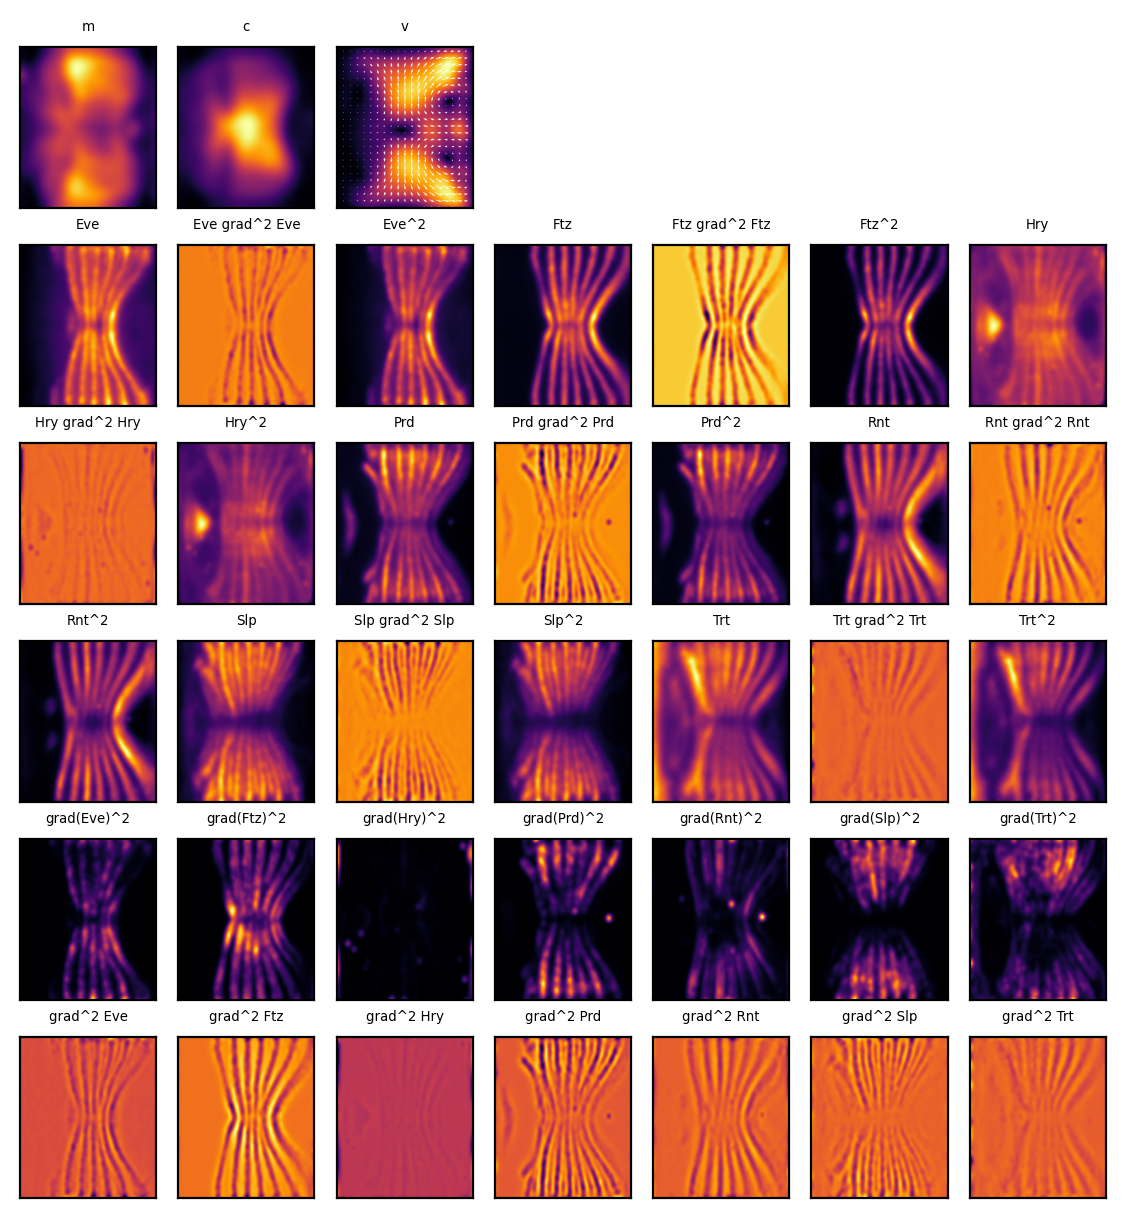

In [27]:
from math import ceil

traj = 0
tt = 35
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

with h5py.File('scalar_ic_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    ti = np.argmin(np.abs(lib['t'][()] - tt))
    
    keys = list(lib['U_raw'].keys())
    n_plots = len(keys)

    n_cols = 7
    n_rows = ceil(n_plots / n_cols)
    fig, ax = plt.subplots(n_rows+1, n_cols, 
                       figsize=(n_cols*.8, n_rows+1),
                       sharey=True, sharex=True, dpi=200)
    ax = ax.flatten()
    ax[0].set_title('m')
    color_2D(ax[0], lib['fields/Tr(m)'][ti][()])
    ax[1].set_title('c')
    color_2D(ax[1], lib['fields/Tr(c)'][ti][()])
    ax[2].set_title('v')
    plot_vector2D(ax[2], lib['fields/v'][ti][()])
    for i in range(3, n_cols):
        ax[i].axis('off')
        
    for i, key in enumerate(keys):
        ui = lib['U_raw'][key]
        t = ui.attrs['t']
        ii = np.argmin(np.abs(t - tt))
        color_2D(ax[i+n_cols], gaussian_filter(ui[ii][()], sigma=3))
        ax[i+n_cols].set_title(key)

    plt.tight_layout()

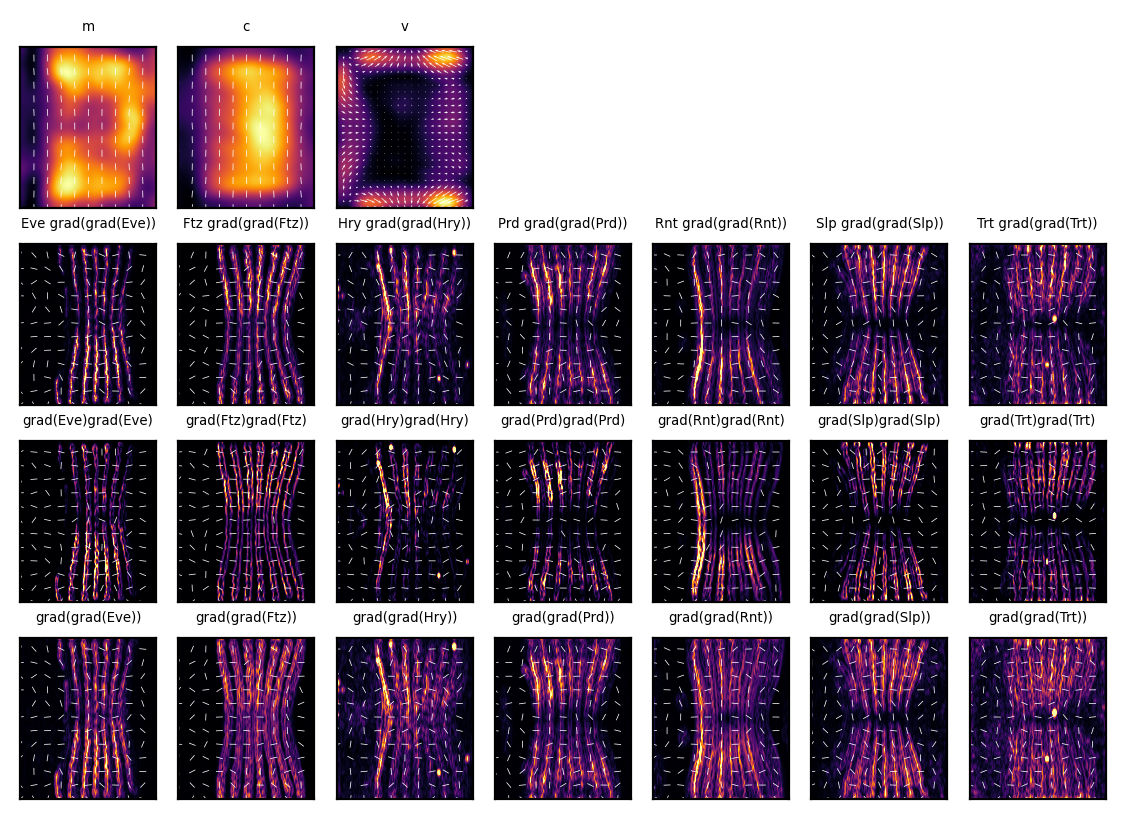

In [39]:
from math import ceil

traj = 0
tt = 10
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

with h5py.File('tensor_ic_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    ti = np.argmin(np.abs(lib['t'][()] - tt))
    
    keys = list(lib['U_raw'].keys())
    n_plots = len(keys)

    n_cols = 7
    n_rows = ceil(n_plots / n_cols)
    fig, ax = plt.subplots(n_rows+1, n_cols, 
                       figsize=(n_cols*.8, n_rows+1),
                       sharey=True, sharex=True, dpi=200)

    ax = ax.flatten()
    ax[0].set_title('m')
    plot_tensor2D(ax[0], lib['fields/m'][ti][()])
    ax[1].set_title('c')
    plot_tensor2D(ax[1], lib['fields/c'][ti][()])
    ax[2].set_title('v')
    plot_vector2D(ax[2], lib['fields/v'][ti][()])
    for i in range(3, n_cols):
        ax[i].axis('off')
    
    for i, key in enumerate(keys):
        ui = lib['U_raw'][key]
        t = ui.attrs['t']
        ii = np.argmin(np.abs(t - tt))
        plot_tensor2D(ax[i+n_cols], smooth_stack(ui[ii][()], sigma=0), both=False, vmax_std=5)
        ax[i+n_cols].set_title(key)

    plt.tight_layout()

In [10]:
from utils.pca_translation_utils import *

def collect_pca_data(h5f, key, tmin, tmax, keep, scale_units=False):
    '''
    Collect the PCA data froma  given h5f library and return X, U, Y0, and the relevant variable names

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything

        the returned scale_array is the unit factor we need to multiply by to get to units of key / time
        these are the units of the feature
        Each feature should be multiplied by these units, and its coefficient should be divided by them
    '''
    t_X = h5f['t'][()].astype(int)
    t_U = h5f['U_pca'].attrs['t']

    feature_names = list(h5f['X_pca'][key].attrs['feature_names'])
    control_names = list(h5f['U_pca'][key].attrs['feature_names'])

    u_mask = np.logical_and(t_X >= np.min(t_U), t_X <= np.max(t_U))
    x_mask = np.logical_and(t_X >= tmin, t_X <= tmax)
    t_mask = np.logical_and(x_mask, u_mask)
    times = t_X[t_mask]

    X = h5f['X_pca'][key][t_mask, ...][..., keep, :][()]
    Y0 = h5f['y0_pca'][key][t_mask, ...][..., keep, :][()]

    x_mask = np.logical_and(t_U >= np.min(t_X), t_U <= np.max(t_X))
    u_mask = np.logical_and(t_U >= tmin, t_U <= tmax)
    t_mask = np.logical_and(x_mask, u_mask)
    U = h5f['U_pca'][key][t_mask, ...][..., keep, :][()]

    scale_array = np.ones(X.shape[-1] + U.shape[-1])
    if scale_units:
        fields = h5f['fields']
        for i, feature in enumerate(feature_names):
            attrs = h5f['X_raw'][feature].attrs
            for unit in attrs:
                if unit in fields:
                    scale_array[i] /= fields[unit].attrs['std'] ** attrs[unit]
                elif unit == 'space':
                    scale_array[i] *= fields['v'].attrs['std'] ** attrs[unit]
        for i, feature in enumerate(control_names):
            j = len(feature_names) + i
            attrs = h5f['U_raw'][feature].attrs
            for unit in attrs:
                if unit in fields:
                    scale_array[j] /= fields[unit].attrs['std'] ** attrs[unit]
                elif unit == 'space': #Spatial derivative means must multiply by a spatial unit
                    scale_array[j] *= fields['v'].attrs['std'] ** attrs[unit]
        scale_array *= fields[key].attrs['std'] #Multiply everything by units of key

    return X, U, Y0, times, feature_names, control_names, scale_array

def collect_raw_data(h5f, key, tmin, tmax, keep, scale_units=False, U_only=False):
    '''
    Collect the PCA data froma  given h5f library and return X, U, Y0, and the relevant variable names

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything

        the returned scale_array is the unit factor we need to multiply by to get to units of key / time
        these are the units of the feature
        Each feature should be multiplied by these units, and its coefficient should be divided by them
    '''
    t_X = h5f['t'][()].astype(int)
    t_U = h5f['U_pca'].attrs['t']

    feature_names = list(h5f['X_pca'][key].attrs['feature_names'])
    control_names = list(h5f['U_pca'][key].attrs['feature_names'])

    u_mask = np.logical_and(t_X >= np.min(t_U), t_X <= np.max(t_U))
    x_mask = np.logical_and(t_X >= tmin, t_X <= tmax)
    t_mask = np.logical_and(x_mask, u_mask)
    times = t_X[t_mask]

    Y0 = h5f['X_raw'][key][t_mask, ...][()]
    
    space_mask = np.random.random(Y0.shape[-2:]) > 0.5
    Y0 = Y0[..., space_mask][..., None]
    
    X = []
    if not U_only:
        for feature in feature_names:
            X.append(h5f['X_raw'][feature][t_mask, ...][..., space_mask][()])

    x_mask = np.logical_and(t_U >= np.min(t_X), t_U <= np.max(t_X))
    u_mask = np.logical_and(t_U >= tmin, t_U <= tmax)
    t_mask = np.logical_and(x_mask, u_mask)
    
    for feature in control_names:
        X.append(h5f['U_raw'][feature][t_mask, ...][..., space_mask][()])
    
    X = np.stack(X, axis=-1)
    
    scale_array = np.ones(X.shape[-1])
    if scale_units:
        fields = h5f['fields']
        if not U_only:
            for i, feature in enumerate(feature_names):
                attrs = h5f['X_raw'][feature].attrs
                for unit in attrs:
                    if unit in fields:
                        scale_array[i] /= fields[unit].attrs['std'] ** attrs[unit]
                    elif unit == 'space':
                        scale_array[i] *= fields['v'].attrs['std'] ** attrs[unit]
        for i, feature in enumerate(control_names):
            j = i if U_only else len(feature_names) + i
            attrs = h5f['U_raw'][feature].attrs
            for unit in attrs:
                if unit in fields:
                    scale_array[j] /= fields[unit].attrs['std'] ** attrs[unit]
                elif unit == 'space': #Spatial derivative means must multiply by a spatial unit
                    scale_array[j] *= fields['v'].attrs['std'] ** attrs[unit]
        scale_array *= fields[key].attrs['std'] #Multiply everything by units of key
    
    if U_only:
        feature_names = control_names
    else:
        feature_names += control_names
    
    return X, Y0, times, feature_names, scale_array

def fit_sindy_model(h5f, key, tmin, tmax, keep, threshold=1e-1, alpha=1e-1, scale_units=False, U_only=False):
    '''
    Fit a SINDy model on data filled by a given key in an h5py file
    Fit range goes from tmin to tmax, and is applied on a set keep of PCA components

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything
    '''
    X, Y0, scales = [], [], []
    eIds = list(h5f.keys())
    for eId in eIds:
        if not eId == 'ensemble': continue
        x, y0, times, feature_names, scale = collect_raw_data(
            h5f[eId],
            key,
            tmin,
            tmax,
            keep,
            scale_units,
            U_only,
        )
        if len(x) == 0:
            continue
        X.append(x * scale)
        Y0.append(y0)
        scales.append(scale)

    scales = np.mean(scales, axis=0)
    sindy = ps.SINDy(
        feature_library=ps.IdentityLibrary(),
        optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, fit_intercept=True),
        feature_names=feature_names,
    )
    sindy.fit(x=X, x_dot=Y0, multiple_trajectories=True)
    sindy.model.steps[-1][1].optimizer.coef_[:] *= scales
    sindy.print(lhs=[key])
    return sindy
    
def sindy_predict(data, key, sindy, pca, keep, 
                  tmin=None, tmax=None, smooth_U=7):
    '''
    Translate a field from an embryo using a SINDy model
    Rather than forecasting the PCA components, 
        we integrate the evolution of the fields directly
    '''
    #Collect library from h5py dataset
    t_X = data['t'][()].astype(int)
    t_U = data['U_pca'].attrs['t']

    if tmin is None:
        tmin = max(np.min(t_X), np.min(t_U))
    if tmax is None:
        tmax = min(np.max(t_X), np.max(t_U))
    time = t_X[np.logical_and(t_X >= tmin, t_X <= tmax)]

    x_true = data['fields'][key]
    x_int = interp1d(t_X, x_true, axis=0)
    ic = x_int(tmin)

    times = np.arange(tmin, tmax+1)
    
    x_pred = np.zeros([tmax-tmin+1, *x_true.shape[1:]])
    coefs = sindy.coefficients()[0]
    for i, feature in enumerate(sindy.feature_names):
        if feature in data['X_raw']:
            t_mask = np.logical_and(t_X >= tmin, t_X <= tmax)
            x_pred += coefs[i] * data['X_raw'][feature][t_mask, ...]
        else:
            t_mask = np.logical_and(t_U >= tmin, t_U <= tmax)
            ui = data['U_raw'][feature][t_mask, ...][()]
            if smooth_U:
                ui = smooth_stack(ui, sigma=smooth_U)
            x_pred += coefs[i] * ui

    return x_pred, x_int, times

c = -0.777 Eve grad(grad(Eve)) + -0.076 Ftz grad(grad(Ftz)) + 0.966 grad(Eve)grad(Eve) + 0.239 grad(Ftz)grad(Ftz) + 2.648 grad(Hry)grad(Hry) + 10.336 grad(Prd)grad(Prd) + 1.546 grad(Rnt)grad(Rnt) + 3.892 grad(Slp)grad(Slp) + 5.263 grad(Trt)grad(Trt) + 1.892 grad(grad(Eve)) + 0.162
PCA Component R2=-7.34667	MSE=1.80113


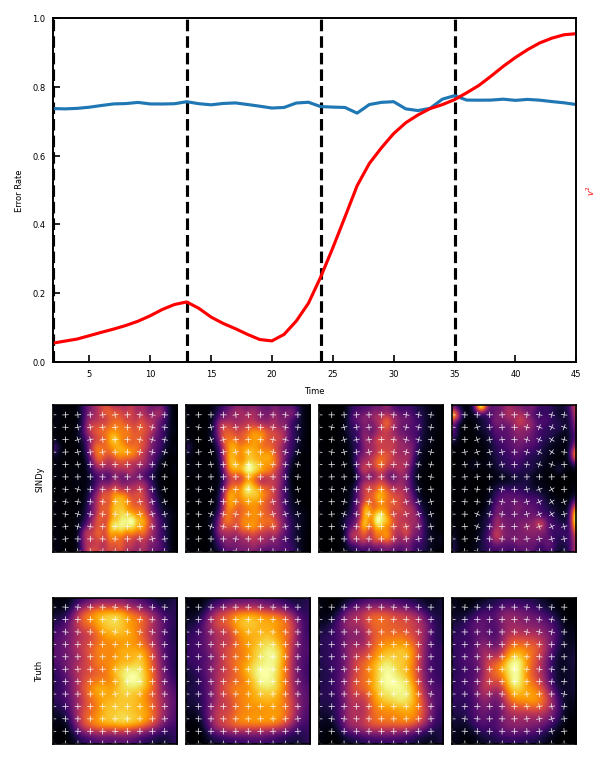

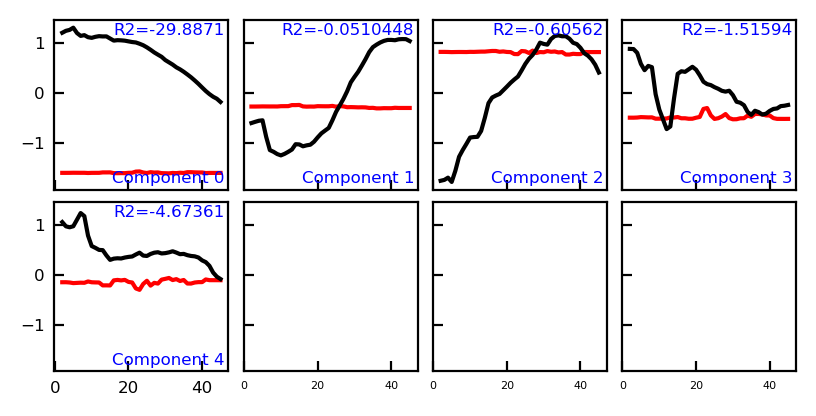

In [40]:
lib_path = '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/ECad-GFP'
lib_key, library, plot_fn, evr = 'Tr(c)', 'scalar', color_2D, 0.99
lib_key, library, plot_fn, evr = 'c', 'tensor', lambda ax, f: plot_tensor2D(ax, f, both=True), 0.95

with h5py.File('%s_ic_fitting.h5' % library, 'r') as h5f:
    pca = pk.load(open(os.path.join(lib_path, '%s_PCA.pkl' % library), 'rb'))
    info = dict(
        key=lib_key,
        tmin=2, tmax=10,
        #tmin=30, tmax=45,
        scale_units=True,
        U_only=True,
        keep=np.cumsum(pca.explained_variance_ratio_) <= evr,
        threshold=1e-1,
        alpha=1e2,
    )
    sindy = fit_sindy_model(h5f, **info)
    
    data = h5f['ensemble']
    tmin = max(info['tmin'], int(np.min(data['t'])))
    tmax = 45

    pred, interp, times = sindy_predict(data, lib_key, sindy, pca, info['keep'], tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, pca, times, info['keep'], data, plot_fn=plot_fn)
    pca_predictions_plot(pred, interp, pca, times, info['keep'])

m = 0.228 grad(Eve)grad(Eve) + 0.086 grad(Ftz)grad(Ftz) + 0.980 grad(Hry)grad(Hry) + 2.890 grad(Prd)grad(Prd) + 0.275 grad(Rnt)grad(Rnt) + 1.757 grad(Slp)grad(Slp) + 2.129 grad(Trt)grad(Trt) + 0.043
PCA Component R2=-15.1602	MSE=0.551032


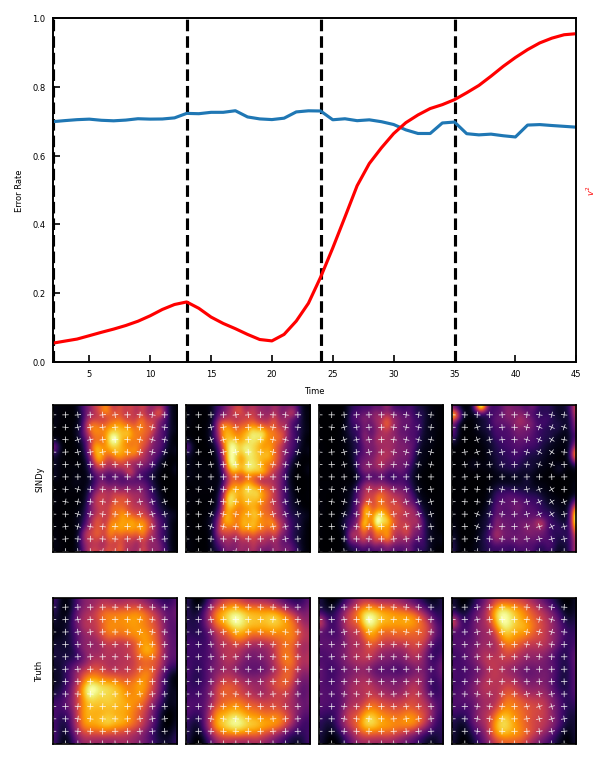

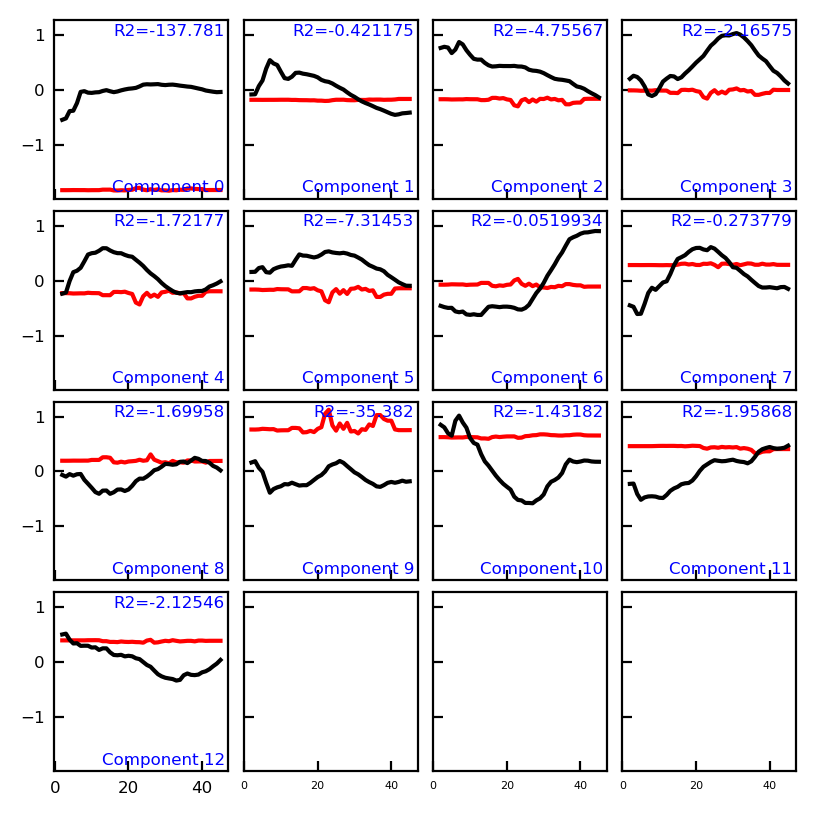

In [42]:
lib_path = '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh-mCherry'
lib_key, library, plot_fn, evr = 'Tr(m)', 'scalar', color_2D, 0.99
lib_key, library, plot_fn, evr = 'm', 'tensor', lambda ax, f: plot_tensor2D(ax, f, both=True), 0.95

with h5py.File('%s_ic_fitting.h5' % library, 'r') as h5f:
    pca = pk.load(open(os.path.join(lib_path, '%s_PCA.pkl' % library), 'rb'))
    info = dict(
        key=lib_key,
        tmin=2, tmax=10,
        #tmin=30, tmax=45,
        scale_units=True,
        U_only=True,
        keep=np.cumsum(pca.explained_variance_ratio_) <= evr,
        threshold=1e-1,
        alpha=2e1,
    )
    sindy = fit_sindy_model(h5f, **info)
    
    data = h5f['ensemble']
    tmin = max(info['tmin'], int(np.min(data['t'])))
    tmax = 45

    pred, interp, times = sindy_predict(data, lib_key, sindy, pca, info['keep'], tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, pca, times, info['keep'], data, plot_fn=plot_fn)
    pca_predictions_plot(pred, interp, pca, times, info['keep'])